In [ ]:
# !pip install yfinance
import keras
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Model Creation

In [ ]:
newModel=Sequential()
newModel.add(LSTM(50,return_sequences=True,input_shape=(100,50)))
newModel.add(LSTM(50,return_sequences=True))
newModel.add(LSTM(50))
newModel.add(Dense(1))
newModel.summary()
newModel.compile(loss='mean_squared_error',optimizer='adam')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,651
Trainable params: 60,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
newModel.save('Save_Model')

INFO:tensorflow:Assets written to: Save_Model/assets


INFO:tensorflow:Assets written to: Save_Model/assets


# Model Training

In [ ]:
ticker = yf.Ticker('MSFT')
df = ticker.history(period='max')
df1 = df.reset_index()['Close']
df2 = pd.DataFrame(df1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:1],df1[training_size:len(df1),:1]

In [ ]:
def create_dataset(dataset, time_step = 1, input_size = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-input_size+1):
		a = []
		for j in range(time_step) :
			a.append(dataset[i+j:(i+j+input_size), 0])
		dataX.append(a)
		dataY.append(dataset[i + time_step + input_size - 1, 0])
	return array(dataX), array(dataY)
 
time_step = 100
input_size = 50
X_train, y_train = create_dataset(train_data, time_step, input_size)
X_test, y_test = create_dataset(test_data, time_step, input_size)

In [ ]:
savedModel = keras.models.load_model('Save_Model')

In [ ]:
savedModel.evaluate(X_test ,y_test )

95/95 [==============================] - 4s 33ms/step - loss: 0.1624


0.16242675483226776

In [ ]:
savedModel.fit(X_test, y_test, epochs=30, verbose=1)

Epoch 1/30
95/95 [==============================] - 17s 133ms/step - loss: 0.0040
Epoch 2/30
95/95 [==============================] - 13s 132ms/step - loss: 5.4148e-04
Epoch 3/30
95/95 [==============================] - 13s 134ms/step - loss: 4.5650e-04
Epoch 4/30
95/95 [==============================] - 13s 133ms/step - loss: 3.7911e-04
Epoch 5/30
95/95 [==============================] - 13s 134ms/step - loss: 4.9654e-04
Epoch 6/30
95/95 [==============================] - 13s 135ms/step - loss: 3.3595e-04
Epoch 7/30
95/95 [==============================] - 13s 132ms/step - loss: 2.9008e-04
Epoch 8/30
95/95 [==============================] - 13s 133ms/step - loss: 2.7434e-04
Epoch 9/30
95/95 [==============================] - 13s 133ms/step - loss: 2.7624e-04
Epoch 10/30
95/95 [==============================] - 13s 133ms/step - loss: 2.4687e-04
Epoch 11/30
95/95 [==============================] - 12s 130ms/step - loss: 2.4401e-04
Epoch 12/30
95/95 [==============================] - 13s

In [ ]:
savedModel.evaluate(X_test ,y_test )

95/95 [==============================] - 3s 32ms/step - loss: 1.5021e-04


0.00015020962746348232

In [ ]:
savedModel.save('Save_Model')

INFO:tensorflow:Assets written to: Save_Model/assets


INFO:tensorflow:Assets written to: Save_Model/assets


In [ ]:
train_predict = savedModel.predict(X_train)
test_predict = savedModel.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
l = len(df2) - len(test_predict)
test = df2[l:]
train = df2[:l]
test['Predictions'] = test_predict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


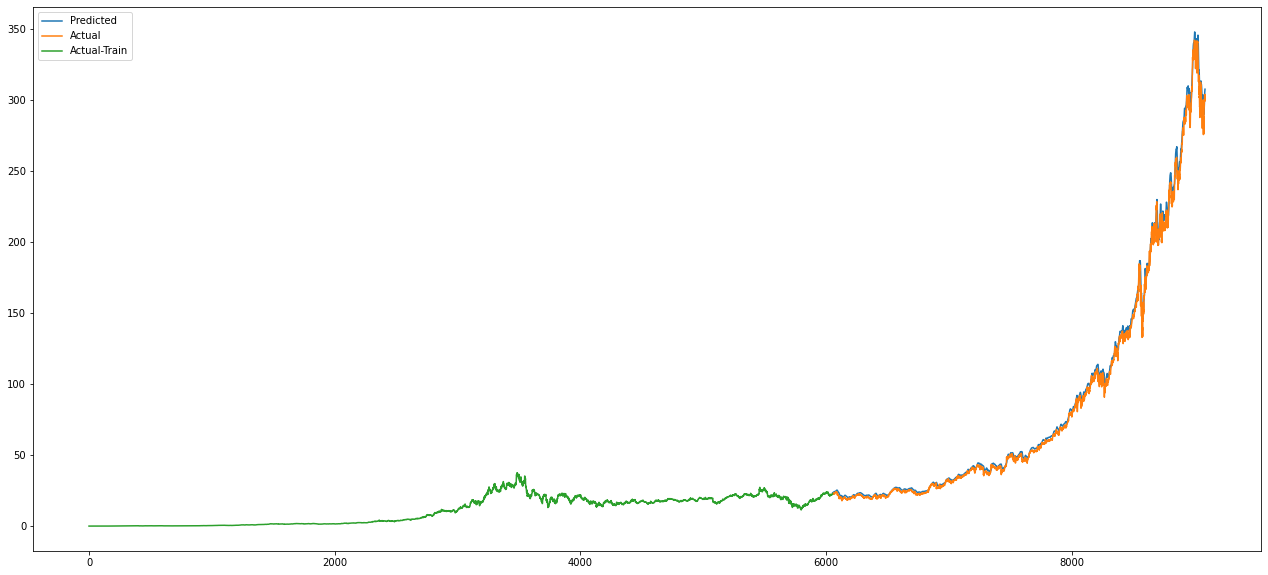

In [ ]:
plt.figure(figsize=(22, 10))
plt.plot(test[['Predictions', 'Close']])
plt.plot(train.Close)
plt.legend(['Predicted', 'Actual', 'Actual-Train'])

# Model Future Predict

In [ ]:
def create_first_dataset(dataset, time_step = 1, input_size = 1):
	a = []
	for j in range(time_step) :
		a.append(dataset[j:(j+input_size),0])
	return array(a)



In [ ]:
savedModel = keras.models.load_model('Save_Model')


In [ ]:
NumberOfFutureDays = 50

In [ ]:
x_input = df1[-149:]
temp_list = create_first_dataset(x_input,100,50)
temp_list = temp_list.reshape(1,100,50)

In [ ]:
lst_output=[]
n_steps=100
i=0

temp = temp_list

while(i<NumberOfFutureDays):
    yhat = savedModel.predict(temp, verbose=0)
    lst_output.extend(yhat.tolist())
    new_input = temp[0,-1,1:]
    new_input = np.append(new_input, yhat)
    temp = temp[0,1:]
    temp = np.append(temp, [new_input], axis = 0)
    temp = temp.reshape(1, temp.shape[0],temp.shape[1])
    i=i+1

print(lst_output)
print(len(lst_output))

[[0.9018210172653198], [0.9053292870521545], [0.9098057150840759], [0.9209800362586975], [0.9329641461372375], [0.9440795183181763], [0.9534203410148621], [0.9628472328186035], [0.9710034728050232], [0.9795772433280945], [0.9870467782020569], [0.9930706024169922], [1.001015067100525], [1.0095789432525635], [1.0142347812652588], [1.0161327123641968], [1.0192614793777466], [1.023513913154602], [1.0296603441238403], [1.035045862197876], [1.0406843423843384], [1.0454493761062622], [1.052144169807434], [1.0594557523727417], [1.0641393661499023], [1.0688151121139526], [1.0715327262878418], [1.0741485357284546], [1.0761504173278809], [1.0782852172851562], [1.078870415687561], [1.0805883407592773], [1.0841158628463745], [1.0871162414550781], [1.0899754762649536], [1.0921945571899414], [1.0953348875045776], [1.0985218286514282], [1.1012500524520874], [1.1029694080352783], [1.1037940979003906], [1.1049561500549316], [1.1054928302764893], [1.1062132120132446], [1.1068137884140015], [1.10775291919

In [ ]:
future_p = [i[0] for i in scaler.inverse_transform(lst_output)]
print(future_p)
print(len(future_p))

[308.7909279434205, 309.9919664302701, 311.52444901474104, 315.3499215726105, 319.45262121354864, 323.257912880416, 326.45569647153474, 329.68294538783755, 332.4751930560278, 335.41038019992067, 337.9675378324835, 340.0297637044229, 342.7495111645943, 345.681311020412, 347.27521370793295, 347.92496085787207, 348.9960784822236, 350.45187776195644, 352.5560774385383, 354.3997824189288, 356.3300877040848, 357.96137299253184, 360.2533018877381, 362.75638534319717, 364.3597969237484, 365.9605149981194, 366.8908765192023, 367.78638570274063, 368.4717197828189, 369.2025577930638, 369.4028975178959, 369.9910205112865, 371.19864992613776, 372.2258144269114, 373.2046590592391, 373.96435023417257, 375.0394264963951, 376.13045974220074, 377.064453415557, 377.65306613734407, 377.9353945578754, 378.33321725856035, 378.51694702861414, 378.7635660869071, 378.96917039200054, 379.29067708424475, 379.4277602245403, 379.5058719037679, 379.5930843690289, 379.64246531566704]
50


In [ ]:
future_pred = pd.DataFrame(df2)
for i in range(NumberOfFutureDays):
  future_pred.loc[future_pred.shape[0]] = [None]
print(future_pred)
print((len(df2)))
abcd = future_pred[(len(df2)):]
abcd['predictions'] = future_p

         Close
0     0.061434
1     0.063628
2     0.064725
3     0.063079
4     0.061982
...        ...
9129       NaN
9130       NaN
9131       NaN
9132       NaN
9133       NaN

[9134 rows x 1 columns]
9084


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


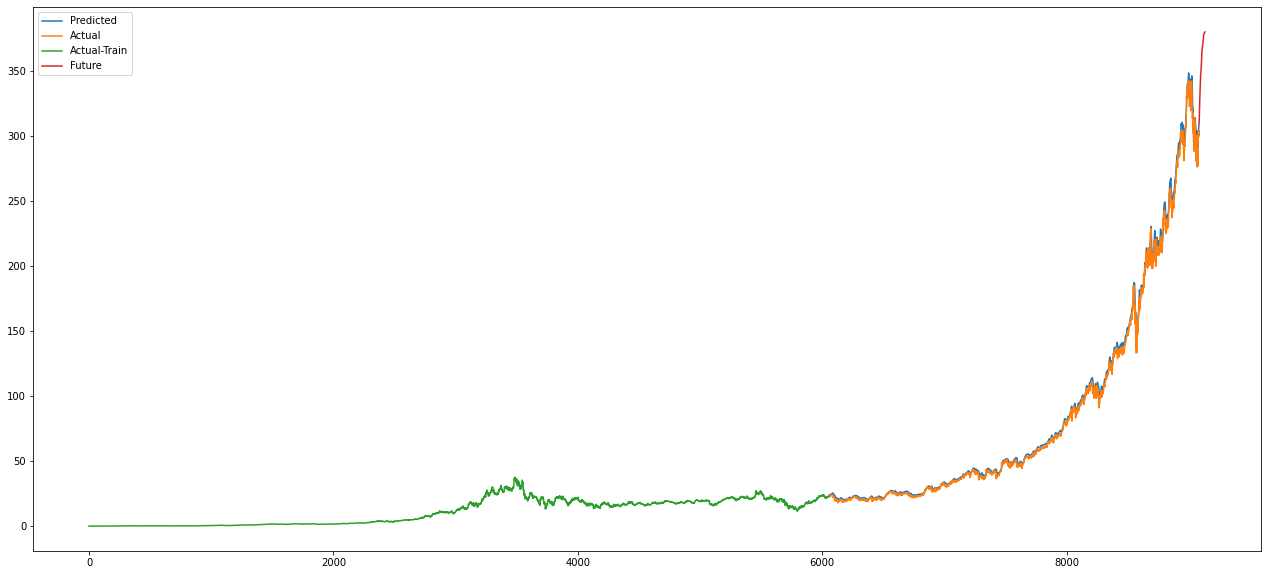

In [ ]:
plt.figure(figsize=(22, 10))
plt.plot(test[['Predictions', 'Close']])
plt.plot(train.Close)
plt.plot(abcd['predictions'])
plt.legend(['Predicted', 'Actual', 'Actual-Train', 'Future'])